In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import neurokit2 as nk
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
import mne
from sklearn.preprocessing import normalize
import torch



In [20]:
# important variables
PRED_LENGTH = 500 # how many samples in the future are we predicting
WINDOW_LENGTH = 1200 # how many samples we look to make predictions
LAGS = 800
TOTAL_LENGTH = PRED_LENGTH + WINDOW_LENGTH

SLIDE_SIZE = 100
INPUT_DIM = 5
OUTPUT_DIM = 5

In [21]:
# load data
file = "physionet.org/files/adfecgdb/1.0.0/r04.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# after normalization 
raw_data = normalize(raw_data,axis=1,norm="max")
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from /home/amirsalimi/ECG_Nexting/physionet.org/files/adfecgdb/1.0.0/r04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [22]:
# cleanup the data
for i in range(len(raw_data)):
    raw_data[i] = nk.ecg_clean(raw_data[i],method="neurokit")

<AxesSubplot:>

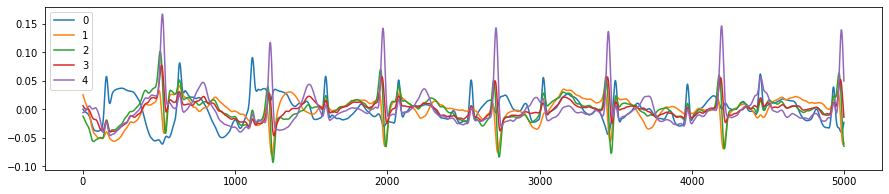

In [23]:
df = pd.DataFrame(raw_data.T).iloc[0:5000]
df.plot(kind="line",figsize=(15,3))

In [24]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, d,WINDOW_LENGTH,PRED_LENGTH,SLIDE_SIZE,):
        'Initialization'
        self.data = d
        self.step_size = SLIDE_SIZE
        self.window_length = WINDOW_LENGTH
        self.pred_length = PRED_LENGTH
        self.num_windows = (d.shape[-1]-self.window_length-self.pred_length)//self.step_size
        print(d.shape[-1],self.num_windows,self.window_length,self.pred_length)
    def __len__(self):
        'Denotes the total number of samples'
        return self.num_windows

    def __getitem__(self, index):
        'Generates one sample of data'
        n = index 
        X = self.data[:,n:n+self.window_length]
        y = self.data[:,n+self.window_length:n+self.window_length+self.pred_length]
        return X, y

In [25]:
sample_size = raw_data.shape[-1]
test_length = sample_size //5

training_set = Dataset(raw_data[:,0:test_length*4],WINDOW_LENGTH,PRED_LENGTH,SLIDE_SIZE)
training_generator = torch.utils.data.DataLoader(training_set,batch_size=1)

testing_set = Dataset(raw_data[:,test_length*4:],WINDOW_LENGTH,PRED_LENGTH,SLIDE_SIZE,)
testing_generator = torch.utils.data.DataLoader(testing_set,batch_size=1)

240000 2383 1200 500
60000 583 1200 500


In [26]:
past,future = testing_set[0][0],testing_set[0][1]

P-value:  0.013674562352257155


/home/amirsalimi/miniconda3/envs/nexting/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


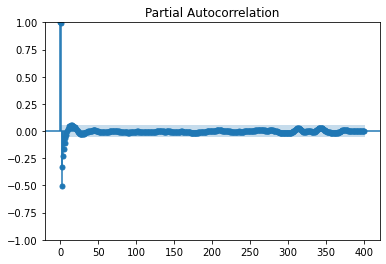

In [27]:
lead = 0
df_stationarityTest = adfuller(past[lead], autolag='AIC')
print("P-value: ", df_stationarityTest[1])
pacf = plot_pacf(past[lead], lags=400)

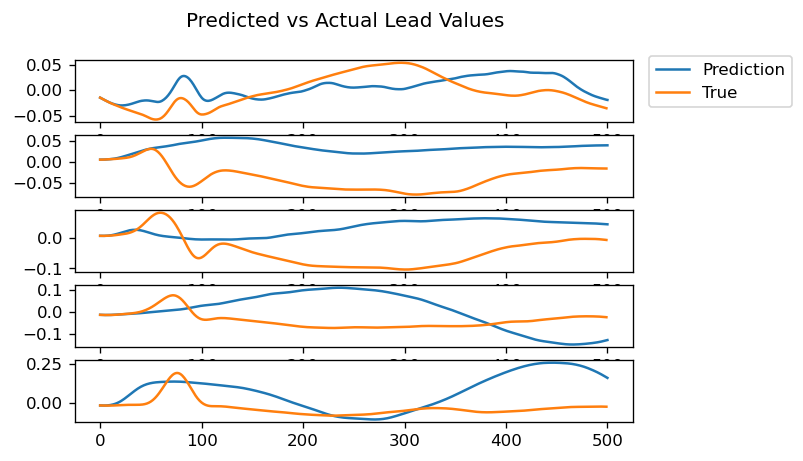

In [28]:
fig, axs = plt.subplots(len(raw_data))
for lead in range(len(raw_data)):
    fig.suptitle('Predicted vs Actual Lead Values')
    ar_model = AutoReg(past[lead], lags=500).fit()
    pred = ar_model.predict(start=WINDOW_LENGTH, end=WINDOW_LENGTH+PRED_LENGTH, dynamic=False)
    axs[lead].plot(pred,label='Prediction')
    axs[lead].plot(future[lead],label='True')

fig.set_dpi(120)
plt.legend(bbox_to_anchor=(1.3, 6))
# fig.ylabel('some numbers')
fig.show()

# improving given more data

In [29]:
from pmdarima.arima import ARIMA
import statsmodels.api as sm

data = sm.datasets.sunspots.load_pandas().data['SUNACTIVITY']
data_1 = data[:len(data)//3]
data_2 = data[len(data)-len(data)//3:]

# This is the standard single fit usage
model = ARIMA(order=(12,0,0))
model.fit(data_1)

# update the model parameters with the new parameters
model.update(data_2)

/home/amirsalimi/miniconda3/envs/nexting/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(12, 0, 0))

In [39]:
X,y = training_set[0]
model = ARIMA(order=(10,0,0))
model.fit(X[0])
out = model.predict(500)
print(np.sqrt(np.mean(y-out)**2))


0.9721885017629674


/home/amirsalimi/miniconda3/envs/nexting/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [94]:
ARIMA?

Init signature:
ARIMA(
    order,
    seasonal_order=(0, 0, 0, 0),
    start_params=None,
    method='lbfgs',
    maxiter=50,
    suppress_warnings=False,
    out_of_sample_size=0,
    scoring='mse',
    scoring_args=None,
    trend=None,
    with_intercept=True,
    **sarimax_kwargs,
)
Docstring:     
An ARIMA estimator.

An ARIMA, or autoregressive integrated moving average, is a
generalization of an autoregressive moving average (ARMA) and is fitted to
time-series data in an effort to forecast future points. ARIMA models can
be especially efficacious in cases where data shows evidence of
non-stationarity.

The "AR" part of ARIMA indicates that the evolving variable of interest is
regressed on its own lagged (i.e., prior observed) values. The "MA" part
indicates that the regression error is actually a linear combination of
error terms whose values occurred contemporaneously and at various times
in the past. The "I" (for "integrated") indicates that the data values
have been replaced 

In [40]:
for i in range(50):
    X,y = training_set[i]
    model.update(X[0],)
    out = model.predict(500)
    print(np.sqrt(np.mean(y[0]-out)**2))

198.75090520818677
1.4103435138539422
1.5123473612446448
1.557200476208553



KeyboardInterrupt



In [84]:

data.shape

(1700,)

In [ ]:
import pmdarima as pm
from pmdarima import model_selection
import matplotlib.pyplot as plt
import numpy as np

# #############################################################################
# Load the data and split it into separate pieces
data = pm.datasets.load_lynx()
data = np.concatenate([X,y],axis =1) [0] [0:500]
train, test = model_selection.train_test_split(data, train_size=400)

# #############################################################################
# Fit with some validation (cv) samples
arima = pm.auto_arima(train, start_p=100, start_q=1,  max_p=400, max_q=100,
                      out_of_sample_size=10, suppress_warnings=True,
                      stepwise=True, error_action='ignore')

# Now plot the results and the forecast for the test set
preds, conf_int = arima.predict(n_periods=test.shape[0],
                                return_conf_int=True)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
x_axis = np.arange(train.shape[0] + preds.shape[0])
axes[0].plot(x_axis[:train.shape[0]], train, alpha=0.75)
axes[0].scatter(x_axis[train.shape[0]:], preds, alpha=0.4, marker='o')
axes[0].scatter(x_axis[train.shape[0]:], test, alpha=0.4, marker='x')
axes[0].fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')

# fill the section where we "held out" samples in our model fit

axes[0].set_title("Train samples & forecasted test samples")

# Now add the actual samples to the model and create NEW forecasts
arima.update(test)
new_preds, new_conf_int = arima.predict(n_periods=10, return_conf_int=True)
new_x_axis = np.arange(data.shape[0] + 10)

axes[1].plot(new_x_axis[:data.shape[0]], data, alpha=0.75)
axes[1].scatter(new_x_axis[data.shape[0]:], new_preds, alpha=0.4, marker='o')
axes[1].fill_between(new_x_axis[-new_preds.shape[0]:],
                     new_conf_int[:, 0],
                     new_conf_int[:, 1],
                     alpha=0.1, color='g')
axes[1].set_title("Added new observed values with new forecasts")
plt.show()